# 자전거 대여수 예측
- X(주변 환경 특성들)로부터 대여수 y 예측
 - 데이터의 순서 정보는 무시
- 시계열 데이터로 보고 선형예측
 - split_seq, walk_forward 모델
 - 데이터의 순서 정보를 사용
- Prophet으로 예측
- 신경망 (MLP, LSTM) 을 이용하는 방법
- 앙상블 기법: 여러 모델을 만든후 평균치를 구한다

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'

# 데이터 다운로드

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/bike_train.csv", parse_dates=["datetime"])
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## datetime 날짜 데이터 분해

In [3]:
df['datetime'].dt.year

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: datetime, Length: 10886, dtype: int64

In [4]:
df["d-year"] = df["datetime"].dt.year
df["d-month"] = df["datetime"].dt.month
df["d-day"] = df["datetime"].dt.day
df["d-hour"] = df["datetime"].dt.hour
df["d-dayofweek"] = df["datetime"].dt.dayofweek

df[["datetime", "d-year", "d-month", "d-day", "d-hour","d-dayofweek" ]].head()

,datetime,d-year,d-month,d-day,d-hour,d-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


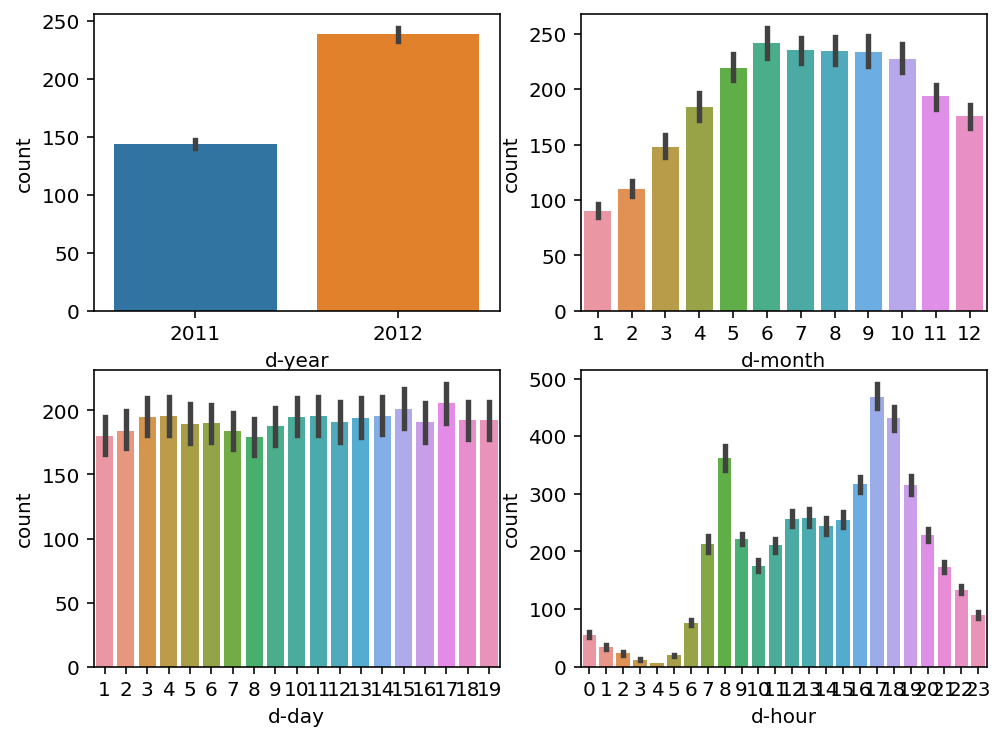

In [5]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
              figsize=(8,6))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.barplot(data=df, x="d-hour", y="count", ax=ax4)

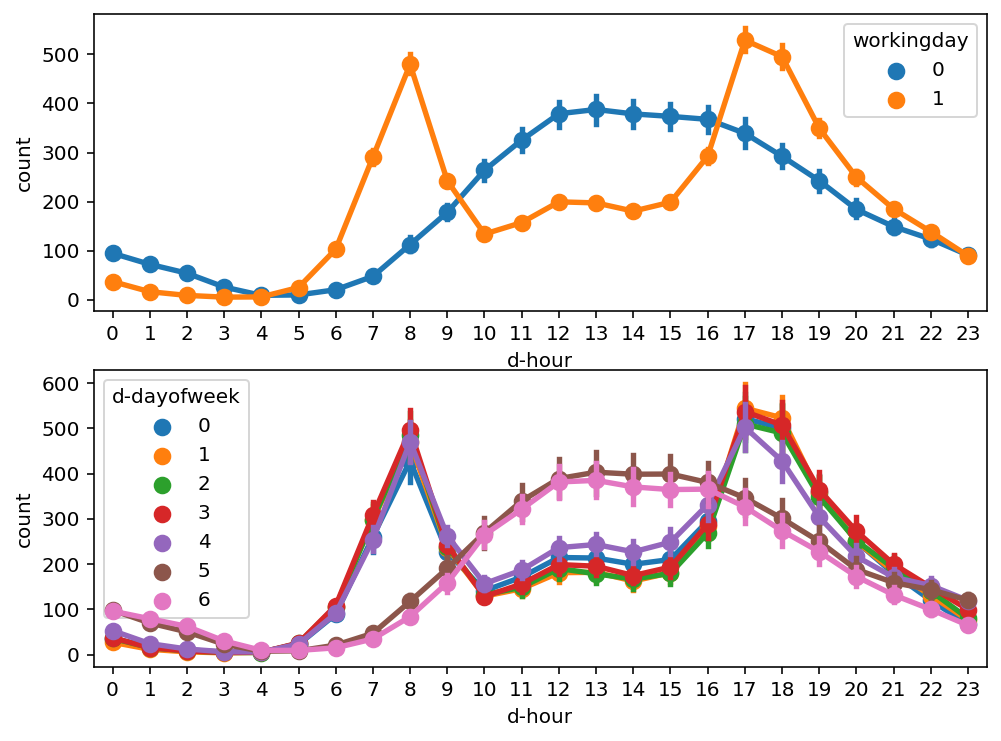

In [6]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(8, 6)

sns.pointplot(data=df, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=df, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 훈련에 사용할 특성 선택

In [7]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-dayofweek'],
      dtype='object')

In [43]:
features = ["season", "holiday", "workingday", "weather", "temp", "atemp", 
            "humidity", "windspeed", "d-year", "d-hour", "d-dayofweek"]

features = ["season", "holiday", "workingday", "d-hour", "d-dayofweek"]

## X -> y 모델
- 랜덤 포레스트
- 데이터 셔플링 (train_test_split)

In [44]:
X = df[features]
X[:3]

,season,holiday,workingday,d-hour,d-dayofweek
0,1,0,0,0,5
1,1,0,0,1,5
2,1,0,0,2,5


In [45]:
X = df[features]
y = df['count'] # 시리즈
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
y.values

array([ 16,  40,  32, ..., 168, 129,  88])

In [47]:
model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.7262868048054351

### 주요 특성 변수

In [16]:
def show_feature_importances(features, importances):
    df = pd.DataFrame({'feature':features,'importance':importances})
    df = df.sort_values('importance', ascending=False)
    ypos = np.arange(len(df.feature))

    plt.figure(figsize=(6,4))
    plt.barh(df.feature, df.importance)
    plt.yticks(ypos, df.feature)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.xlim(0, 1)
    plt.ylim(-1, len(df.feature))
    plt.show()

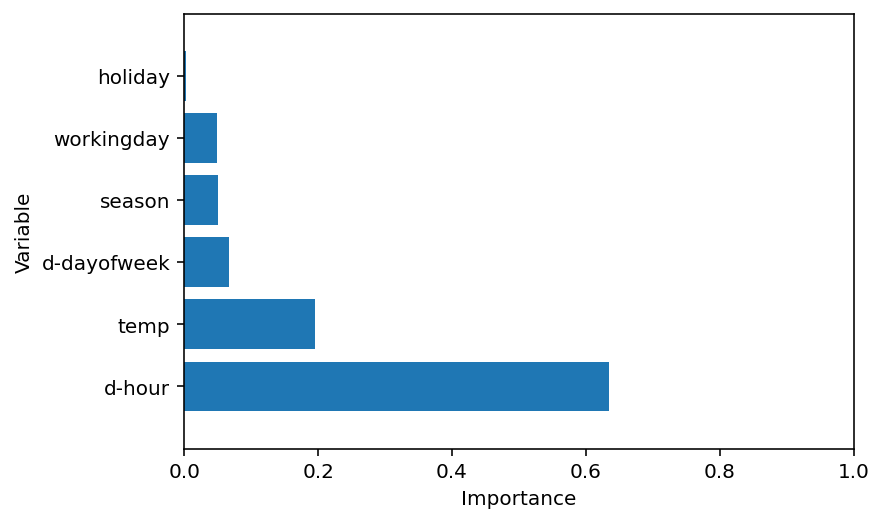

In [17]:
show_feature_importances(features, model.feature_importances_)

### 시각화 함수

In [21]:
y_test

8572    203
957     228
5600    256
76      179
735      11
       ... 
5056    171
6441    130
9730    514
3303    324
7121     74
Name: count, Length: 2722, dtype: int64

In [19]:
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("rmse=", np.sqrt((error**2).mean()).round(4))
    print("max error=", max(error).round(4))
    #  잔차  (residue) 산포도
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.-', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

In [25]:
X_test

,season,holiday,workingday,temp,d-hour,d-dayofweek
8572,3,0,1,38.54,13,2
957,1,0,1,7.38,8,4
5600,1,0,0,14.76,11,6
76,1,0,1,5.74,8,1
735,1,0,1,15.58,0,0
...,...,...,...,...,...,...
5056,4,0,0,15.58,18,6
6441,1,0,1,12.30,15,0
9730,4,0,1,20.50,19,1
3303,3,0,0,36.90,13,6


MAE= 55.9965
rmse= 90.0055
max error= 651.61
R2= 0.7529


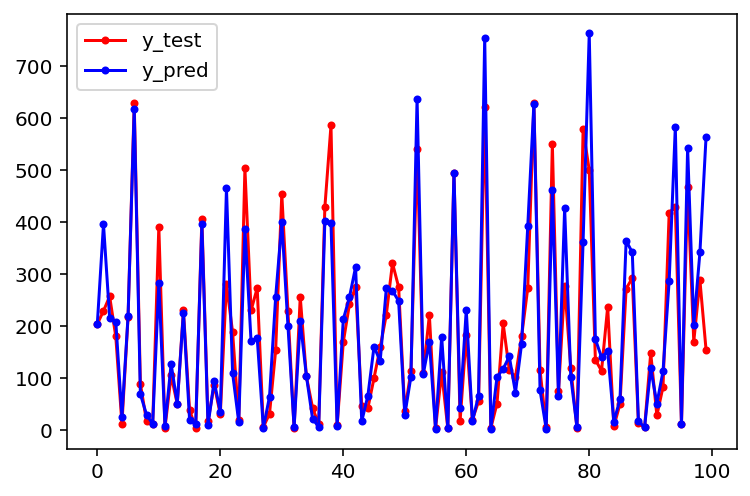

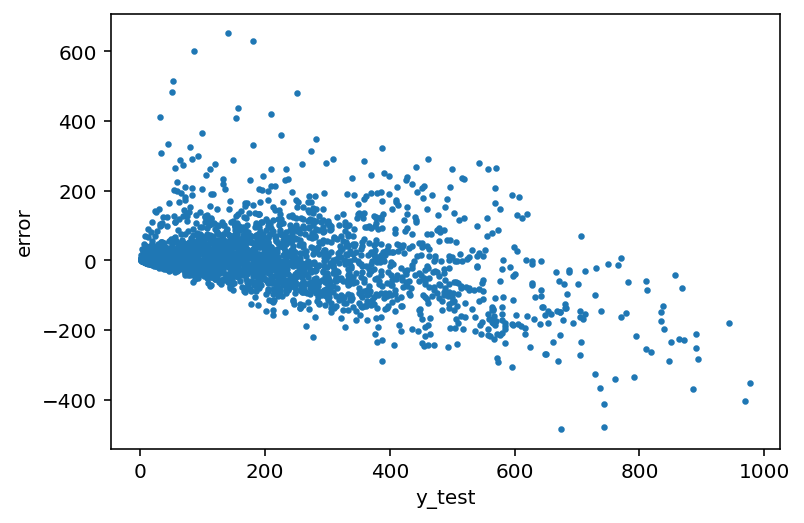

In [23]:
y_pred = model.predict(X_test)
show_regression_result(y_test.values, y_pred)

In [26]:
np.vstack((y_test[:10], y_pred[:10].round(1))).T

array([[203. , 203.9],
       [228. , 394.8],
       [256. , 215.2],
       [179. , 207.6],
       [ 11. ,  24.3],
       [217. , 218.7],
       [627. , 615.9],
       [ 88. ,  68.1],
       [ 16. ,  28.5],
       [ 10. ,  10.8]])

# 선형 모델

In [27]:
count = df["count"].values

In [28]:
count

array([ 16,  40,  32, ..., 168, 129,  88])

In [29]:
cut = np.int((len(count)*0.7))
train = count[:cut]
test = count[cut:]
train.shape, test.shape

((7620,), (3266,))

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [30]:
# 입력 윈도우 n_steps_in, 멀티스텝 출력 n_steps_out
def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

In [35]:
z = np.arange(15)
split_seq_2(z, 6 ,5)

(array([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 6],
        [2, 3, 4, 5, 6, 7],
        [3, 4, 5, 6, 7, 8],
        [4, 5, 6, 7, 8, 9]]), array([10, 11, 12, 13, 14]))

## 적절한 n_steps_in 찾기

In [37]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
for n_steps in range(1,24*20,24):
  x_train, y_train = split_seq_2(train, n_steps, 1)
  x_test, y_test = split_seq_2(test, n_steps, 1)
  lr.fit(x_train, y_train) 
  print(n_steps, lr.score(x_test, y_test).round(4))

1 0.6619
25 0.8655
49 0.8773
73 0.8828
97 0.8864
121 0.8903
145 0.8973
169 0.9016
193 0.9009
217 0.9016
241 0.9025
265 0.9014
289 0.9014
313 0.9014
337 0.9009
361 0.9008
385 0.902
409 0.9016
433 0.9007
457 0.9009


### 최적값 선택

240 0.902
MAE= 47.2529
rmse= 67.9179
max error= 453.0031
R2= 0.902


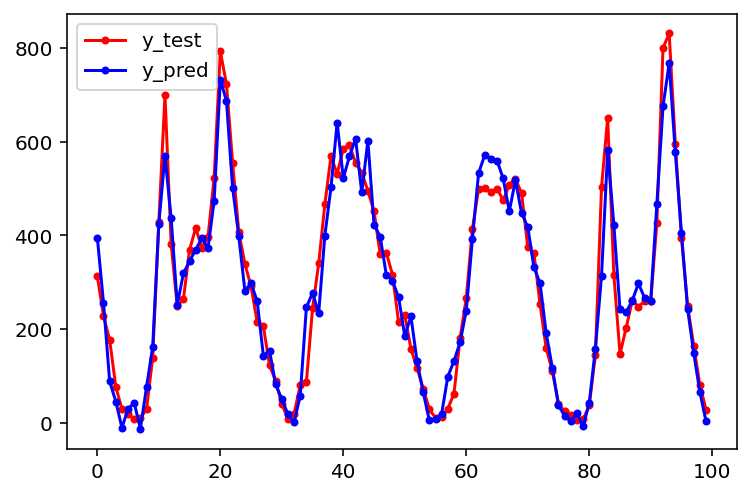

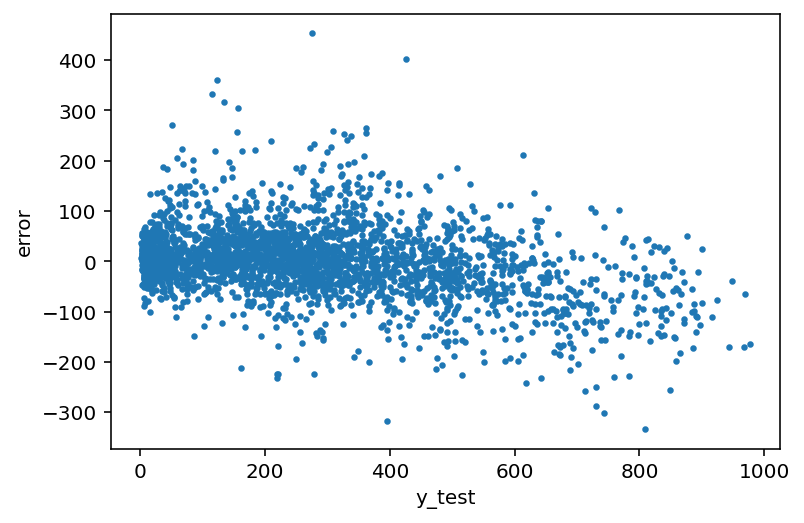

In [38]:
n_steps = 10*24
x_train, y_train = split_seq_2(train, n_steps, 1)
x_test, y_test = split_seq_2(test, n_steps, 1)
lr.fit(x_train, y_train) 
print(n_steps, lr.score(x_test, y_test).round(3))
y_pred = lr.predict(x_test)
show_regression_result(y_test, y_pred)

- 1시간 후를 예측했으므로 정확하다

## 미래 예측

In [39]:
lr = LinearRegression()
n_steps_in = 10*24
n_futures = [1,24, 24*7, 24*7*2, 24*7*3, 24*7*10]
for n_steps_out in n_futures:
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_out, ':', lr.score(x_test, y_test).round(3))

1 : 0.902
24 : 0.767
168 : 0.727
336 : 0.679
504 : 0.596
1680 : -0.386


## 최적값 선택 in, out

In [40]:
n_steps_in = 24*10
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_out, ',', lr.score(x_test, y_test).round(3))

168 , 0.727


In [41]:
lr.coef_

array([ 6.37917435e-02,  3.32557385e-03,  1.38618144e-02, -2.23027426e-02,
       -4.04429234e-02, -4.44489741e-02, -2.92619195e-02, -3.80405335e-02,
        2.40576493e-02, -8.22131186e-03,  5.34192877e-03, -5.41716690e-03,
        1.36222103e-02,  9.41780925e-03,  8.99432098e-03, -1.03859588e-02,
        1.44122599e-02, -1.58063362e-02, -6.50192072e-03, -1.17412226e-02,
       -8.77162899e-05, -5.95419535e-03,  2.28830659e-02,  7.32660389e-02,
       -1.64263125e-02,  6.11249295e-02,  1.86095332e-02,  1.16275257e-02,
       -1.73511377e-03,  3.11397731e-03, -1.29618981e-02, -1.73723563e-02,
       -6.95060101e-03, -3.58437242e-03, -1.60209748e-02,  7.57920948e-03,
       -4.32233277e-03, -6.11796910e-03,  1.57070345e-02, -1.06892740e-02,
        1.60738726e-02,  2.55064672e-02, -2.82324331e-03,  1.69652649e-02,
        1.66568890e-02,  5.66885568e-03,  1.08596487e-02, -1.19668198e-02,
       -1.71904252e-02,  1.92696365e-02,  1.42079265e-02, -2.36401113e-03,
        1.59100438e-03, -

MAE= 80.6557
rmse= 113.0049
max error= 565.6264
R2= 0.7272


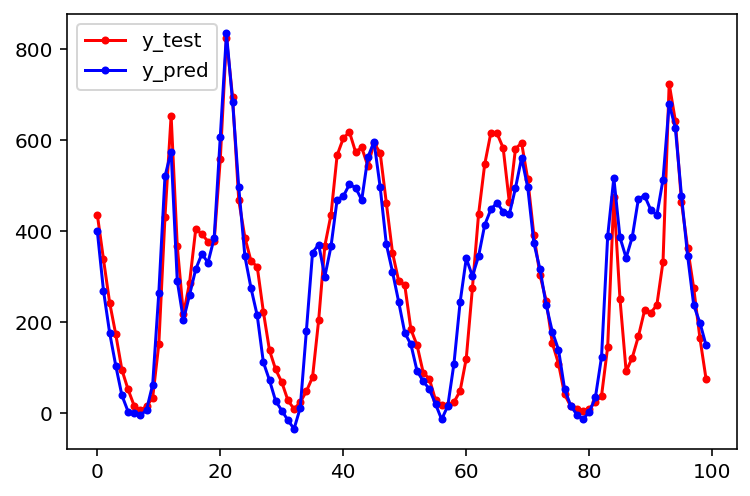

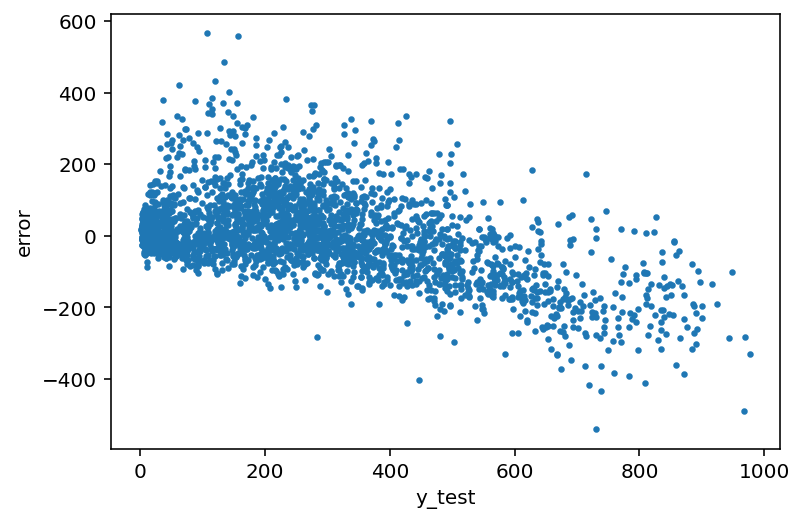

In [42]:
y_pred = lr.predict(x_test)
show_regression_result(y_test, y_pred)

# Prophet

In [48]:
from fbprophet import Prophet
data = df[["datetime","count"]]
data.columns = ["ds","y"]
data.ds.min(), data.ds.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [49]:
train_data = data[:-24*7]
test_data = data[-24*7:]
model = Prophet()
model.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [50]:
train_data.shape, test_data.shape

((10718, 2), (168, 2))

In [51]:
future = test_data[["ds"]]
print(future[:3])
forecast = model.predict(future)

                       ds
10718 2012-12-13 00:00:00
10719 2012-12-13 01:00:00
10720 2012-12-13 02:00:00


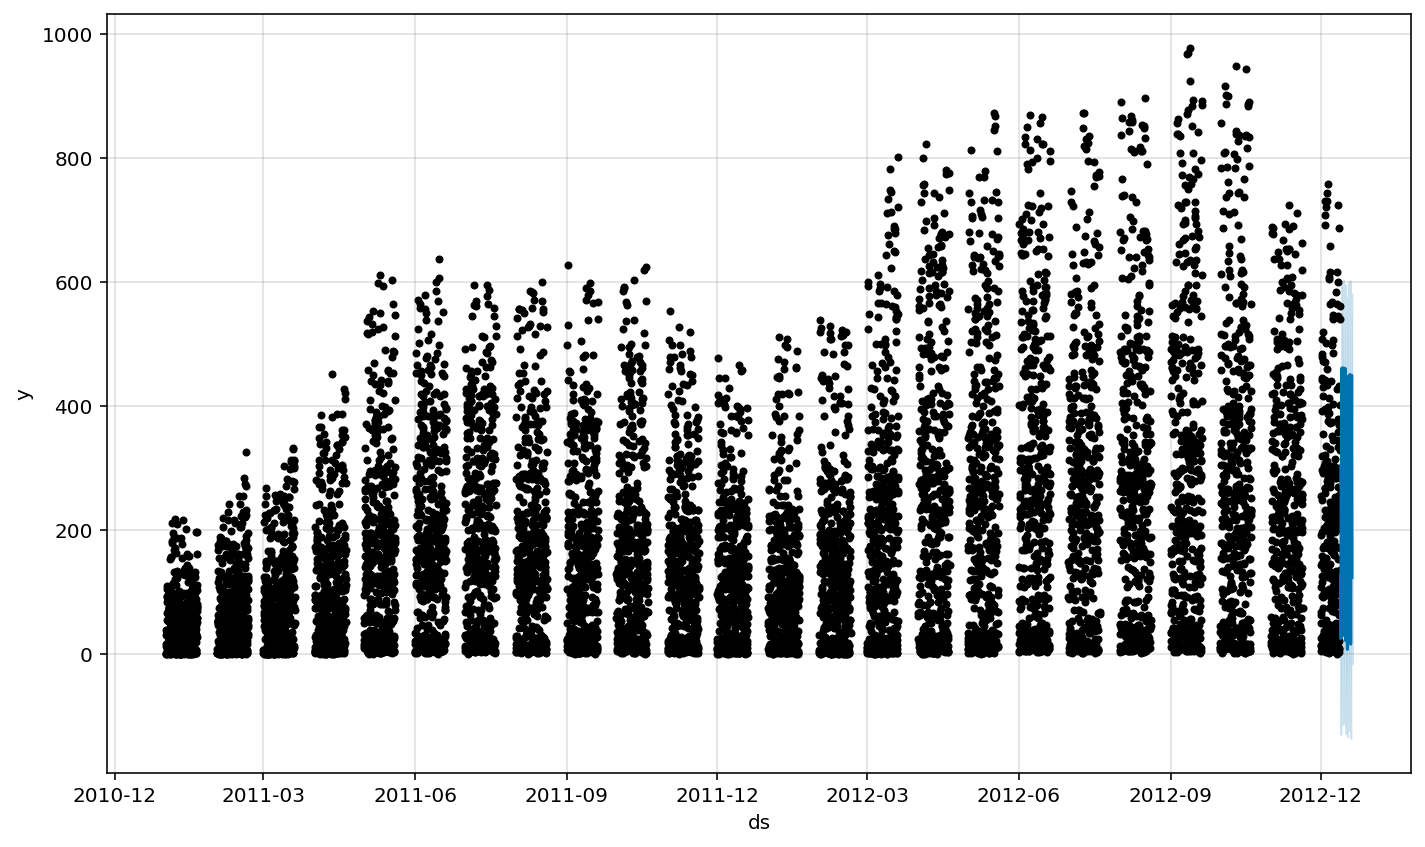

In [52]:
model.plot(forecast)
plt.show()

In [53]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-12-13 00:00:00,236.968245,-21.897214,272.342351,236.968245,236.968245,-110.334864,-110.334864,-110.334864,-110.830957,-110.830957,-110.830957,0.496093,0.496093,0.496093,0.0,0.0,0.0,126.633381
1,2012-12-13 01:00:00,236.953142,-32.908041,265.382234,236.953142,236.953142,-127.973689,-127.973689,-127.973689,-129.014275,-129.014275,-129.014275,1.040586,1.040586,1.040586,0.0,0.0,0.0,108.979453
2,2012-12-13 02:00:00,236.938039,-69.725035,204.901075,236.938039,236.938039,-171.167091,-171.167091,-171.167091,-172.748034,-172.748034,-172.748034,1.580943,1.580943,1.580943,0.0,0.0,0.0,65.770948
3,2012-12-13 03:00:00,236.922937,-128.980382,170.693776,236.922937,236.922937,-211.609038,-211.609038,-211.609038,-213.721603,-213.721603,-213.721603,2.112565,2.112565,2.112565,0.0,0.0,0.0,25.313899
4,2012-12-13 04:00:00,236.907834,-114.602116,169.828172,236.907834,236.907834,-209.396591,-209.396591,-209.396591,-212.027664,-212.027664,-212.027664,2.631073,2.631073,2.631073,0.0,0.0,0.0,27.511243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2012-12-19 19:00:00,234.506506,253.914375,538.329902,234.497035,234.506953,165.718878,165.718878,165.718878,167.838223,167.838223,167.838223,-2.119345,-2.119345,-2.119345,0.0,0.0,0.0,400.225385
164,2012-12-19 20:00:00,234.491404,157.547597,438.007456,234.478710,234.491857,69.750498,69.750498,69.750498,71.377260,71.377260,71.377260,-1.626763,-1.626763,-1.626763,0.0,0.0,0.0,304.241901
165,2012-12-19 21:00:00,234.476301,61.182706,351.179269,234.462988,234.476762,-30.006271,-30.006271,-30.006271,-28.892176,-28.892176,-28.892176,-1.114094,-1.114094,-1.114094,0.0,0.0,0.0,204.470030
166,2012-12-19 22:00:00,234.461198,7.792513,280.170025,234.447191,234.462158,-92.733707,-92.733707,-92.733707,-92.147572,-92.147572,-92.147572,-0.586135,-0.586135,-0.586135,0.0,0.0,0.0,141.727491


In [54]:
y_pred = forecast['yhat'].values
y_test = test_data.y.values

MAE= 76.7672
rmse= 107.1234
max error= 333.7944
R2= 0.6008


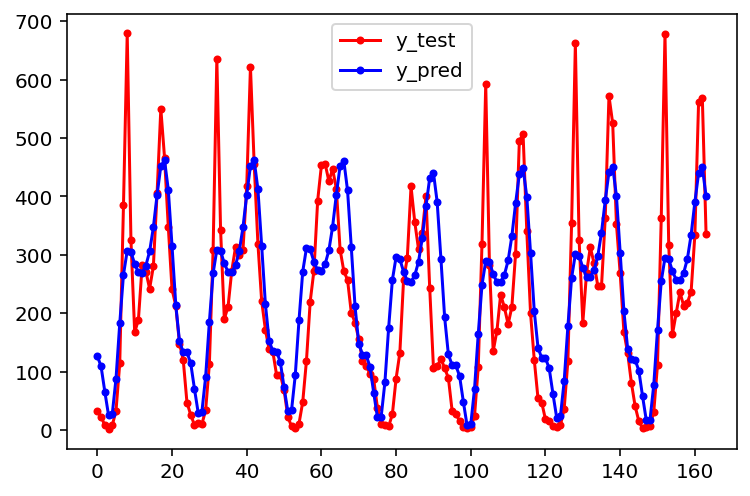

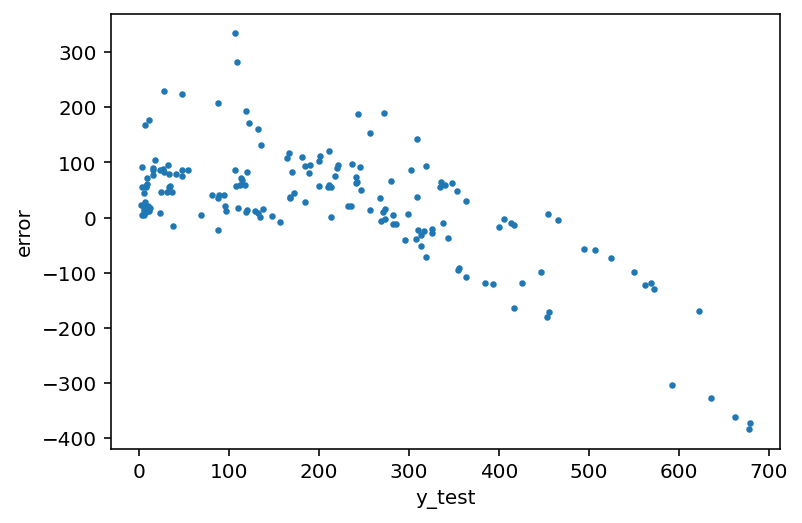

In [55]:
show_regression_result(y_test, y_pred, 164)

## 향 후 3개월간 예측

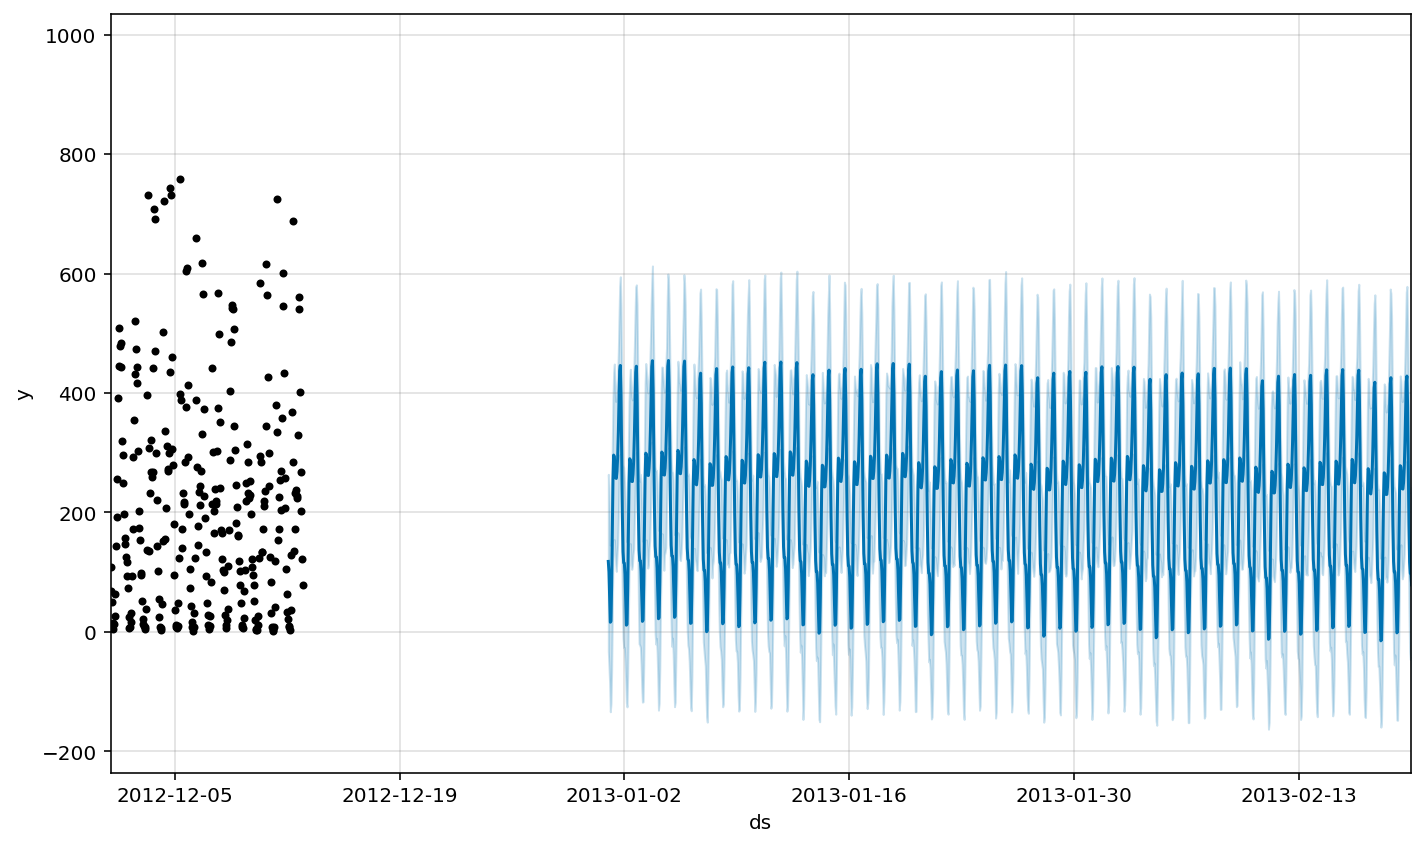

In [58]:
future2 = pd.date_range(start='2013-01-01', end='2013-03-20', 
                       freq='H').to_frame(index=False, name='ds')
forecast = model.predict(future2)
model.plot(forecast)
from datetime import datetime
plt.xlim([datetime(2012, 12, 1), datetime(2013, 2, 20)])
plt.show()
